In [10]:
import os
import json
import numpy as np
from deep_dating.preprocessing import PreprocessRunner
from deep_dating.prediction import DatingPredictor
from deep_dating.metrics import DatingMetrics
from deep_dating.util import save_figure
import matplotlib.pyplot as plt

In [11]:
run_path =  "runs/Feb2-13-25-11/" #"runs/Jan8-19-25-16/" #"runs/Jan6-22-21-16/" #"runs/Dec21-16-31-47"
model_name = "model_epoch_4"
all_labels_, all_outputs_, all_paths_ = DatingPredictor().load(os.path.join(run_path, model_name + "_pred.pkl"))

In [12]:
all_outputs_.shape

(7706,)

In [13]:
with open(os.path.join(run_path, "settings.json"), "r") as f:
    settings = json.load(f)

In [14]:
preds = {}

for i, img_name in enumerate(all_paths_):
    img_name = PreprocessRunner.get_base_img_name(img_name)
    if not img_name in preds:
        preds[img_name] = [all_labels_[i], [all_outputs_[i]]]
    else:
        preds[img_name][1].append(all_outputs_[i])

In [15]:
labels = []
img_preds = []
for val in preds.values():
    labels.append(val[0])
    img_preds.append(np.array(val[1]))

Mean | cs 25 : 90.50772626931567
Median | cs 25 : 94.03973509933775
Min | cs 25 : 79.02869757174393
Max | cs 25 : 84.32671081677704
Mode + Tie Break | cs 25 : 94.03973509933775


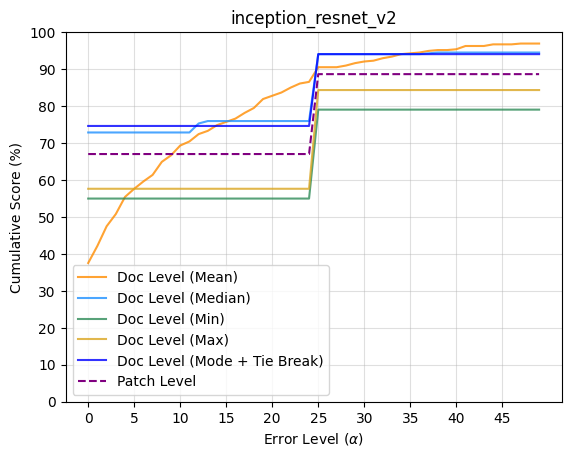

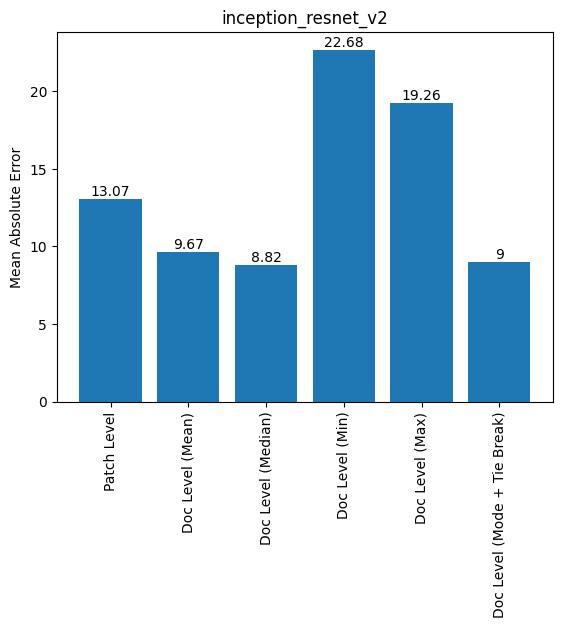

In [16]:
alphas = np.arange(0, 50)
metrics = DatingMetrics(alphas=alphas)

def mode(arr):
    arr = np.round(arr)
    vals, counts = np.unique(arr, return_counts=True)
    index = np.random.choice(np.flatnonzero(counts == counts.max()))
    return vals[index]

agg_funcs = [("Mean", "darkorange", np.mean), ("Median", "dodgerblue", np.median), 
             ("Min", "seagreen", np.min), ("Max", "goldenrod", np.max),
             ("Mode + Tie Break", "blue", mode)]

maes = []
names = []

fig_cs, ax_cs = plt.subplots()
fig_mae, ax_mae = plt.subplots()

for func_name, color, func in agg_funcs:
    pred_agg = []
    label = f"Doc Level ({func_name})"

    for img_vals in img_preds:
        pred_agg.append(func(img_vals))

    metric_vals = metrics.calc(labels, pred_agg)
    mae, mse = tuple(metric_vals[:2])
    maes.append(mae)
    names.append(label)
    cs = metric_vals[2:]
    print(func_name, "| cs", alphas[25], ":", cs[25])
    ax_cs.plot(alphas, cs, label=label, color=color, alpha=0.8)

metric_vals = metrics.calc(all_labels_, all_outputs_)
mae, mse = tuple(metric_vals[:2])
cs = metric_vals[2:]

ax_cs.plot(alphas, cs, label="Patch Level", linestyle="--", color="purple")
ax_cs.set_xlabel(r"Error Level ($\alpha$)")
ax_cs.set_ylabel("Cumulative Score (%)")
ax_cs.set_ylim(0, 100)
ax_cs.set_yticks(np.arange(0, 110, 10))
ax_cs.set_xticks(np.arange(0, 50, 5))
#ax_cs.axvline(x=25, color="red", alpha=0.7)
ax_cs.legend()
ax_cs.grid(alpha=0.4)
ax_cs.set_title(settings["model_name"])
save_figure(model_name + "_cs", fig=fig_cs, fig_dir=run_path)

ax_mae.bar(["Patch Level"] + names, np.round([mae] + maes, 2))
for bars in ax_mae.containers:
    ax_mae.bar_label(bars)

for tick in ax_mae.get_xticklabels():
    tick.set_rotation(90)

ax_mae.set_ylabel("Mean Absolute Error")
ax_mae.set_title(settings["model_name"])
save_figure(model_name + "_mae", fig=fig_mae, show=True, fig_dir=run_path)

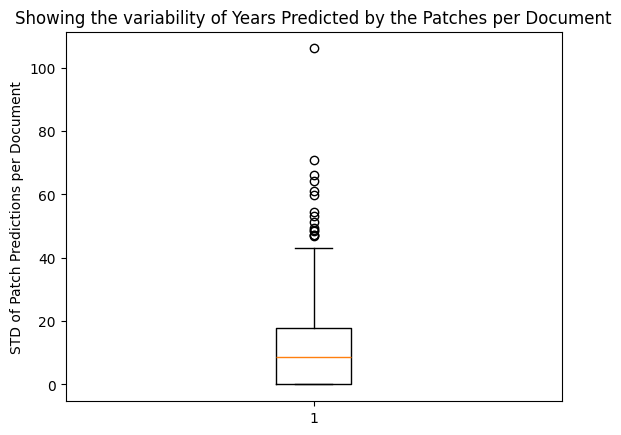

In [17]:
stds = []
for img_vals in img_preds:
    stds.append(np.std(img_vals))

plt.boxplot(stds)
plt.ylabel("STD of Patch Predictions per Document")
plt.title("Showing the variability of Years Predicted by the Patches per Document")
plt.show()

In [18]:
print(preds.keys())

dict_keys(['MPS1425_0148__409_1425', 'MPS1550_0109__320_1550', 'MPS1550_0008__415_1550', 'MPS1450_0248__59_1450', 'MPS1550_0085__270_1550', 'MPS1475_0128__191_1475', 'MPS1300_0040__273_1300', 'MPS1525_0228__207_1525', 'MPS1400_0278__34_1400', 'MPS1500_0123__422_1500', 'MPS1450_0011__263_1450', 'MPS1450_0096__437_1450', 'MPS1300_0005__305_1300', 'MPS1475_0401__209_1475', 'MPS1500_0033__403_1500', 'MPS1425_0199__436_1425', 'MPS1475_0194__370_1475', 'MPS1550_0022__177_1550', 'MPS1400_0054__386_1400', 'MPS1500_0157__253_1500', 'MPS1450_0065__146_1450', 'MPS1450_0305__215_1450', 'MPS1475_0113__67_1475', 'MPS1450_0036__31_1450', 'MPS1450_0258__43_1450', 'MPS1425_0174__421_1425', 'MPS1550_0060__455_1550', 'MPS1500_0038__149_1500', 'MPS1550_0210__244_1550', 'MPS1500_0396__87_1500', 'MPS1550_0002__451_1550', 'MPS1475_0250__249_1475', 'MPS1525_0040__344_1525', 'MPS1475_0127__15_1475', 'MPS1475_0241__378_1475', 'MPS1375_0121__313_1375', 'MPS1400_0103__375_1400', 'MPS1450_0213__326_1450', 'MPS1525